# Ant colony optimization

ACO is inspired by the collective behaviour of ants and usually employed to solve problems on graphs.

This approach relies on stigmergy: an agent leaves a trace of its actions on the environment, the behave of the same agent and of the orher agents is influenced by these traces.

In ant colony optimization we have two components:

- ants, which are stochastic solution building procedures;
    
- pheromone traces, the ants leave pheromone in the search space which evaporates over time, unless reinfoced. The pheromone traces guide the behaviour of the ants.



# ACO for TSP 
Suppose that we have a weighted graph $G = (E,V)$ where $d_{i,\,j}$ is the distance between the vertex $i$ and the vertex $j$

We want to solve the TSP on $G$ (finding the shortest Hamiltonian circuit).

Let us define:

- $\tau_{i,\,j}(t)$ is the amount of pheromones on the edge $(i,j)$ at time $t\;$;

- $h_{i,\,j}$ is the heuristic information that we have on each edge, we set $\eta_{i,\,j}= \frac{1}{d_{i,\,j}}\;$;

- $V^k_i$ is the set of cities that the ant k has yet to visit when it is in city $i$ .

The $k$-th ant will start on a city $i$. It will move to an adjacent city $j$ of the initial city $i$ such that $j \in V^k_i$ with probability
$$
    p^{k}_{i,\,j}(k) =\frac{\tau_{i,\,j}(t)^\alpha \, (\eta_{i,\,j})^\beta}{\sum_{l \in V^k_i}\tau_{i\,l}(t)^\alpha \, (\eta_{i\,l})^\beta}
$$
where $\alpha$ and $\beta$ are parameters controlling how important are the pheromones and the heuristic information, respectively.

Let $L_k$ be the lenght of the solution $S_k$ found by ant $k$.

We define 
$$ 
\Delta \tau_{i,j}^k = 
\begin{cases}
    \frac{1}{L_k} &  \text{if} \; \;(i,j) \in S_k \\
    0 & \text{otherwise}
\end{cases}
$$

The pheromone trails are updated as follows:
$$
 \tau_{i,j}(t+1) = (1-\rho)\tau_{i,j}(t) + \sum_{k=1}^n \Delta \tau_{i,j}^k
$$
where $\rho \in [0,1]$ is a parameter used to decide how fast the pheromones evaporates.

In [45]:
import random
import numpy as np 
import matplotlib.pyplot as plt

In [46]:
class Graph():
    def __init__(self, n_vertices, directed=True):
        self.n_vertices = n_vertices # number of vertices
        self.directed = directed # if directed, then the edges are ordered pairs
        self.adjacency_matrix = np.zeros((n_vertices,n_vertices)) # adjacency matrix

    def add_edge(self, start, end, weight=1):
        self.adjacency_matrix[start][end] = weight
        if self.directed == False:
            self.adjacency_matrix[end][start] = weight  


In [47]:
class ACO4TSP():
    def __init__(self,graph, n_ants, alpha, beta, rho, initial_pheromone_value=0.001):
        # Parameters of the TSP
        self.graph = graph
        self.n_cities = graph.n_vertices
        
        #Parameters of the ACO
        self.n_ants = n_ants
        self.ants_position = None # array of positions of each ant
        self.visited_cities = [[] for ant in range(n_ants)] # list of cities visited by each ant
        self.alpha = alpha # pheromone importance
        self.beta = beta # heuristic importance
        self.rho = rho # evaporation rate
        self.initial_pheromone_value = initial_pheromone_value 
        self.pheromone_matrix = np.full((self.n_cities,self.n_cities), self.initial_pheromone_value) # pheromone matrix
    
        # History of the algorithm
        self.best_solution = None # best solution found
        self.best_solution_length = np.infty # length of the best solution found
        self.history = [] # history of the best solution found in each iteration
    
    def path_length(self, path):
        '''
            Method to calculate the length of a path.
        '''
        distances = np.array([self.graph.adjacency_matrix[path[i]][path[i+1]] for i in range(len(path)-1)])
        total = np.sum(distances)
        return total

    def heuristic(self, current_city, next_city):
        '''
            Method to calculate the heuristic value between two cities.
        '''
        h = 1/self.graph.adjacency_matrix[current_city][next_city]
        return h
    
    def update_visited(self):
        '''
            Method to update the visited cities list.
        '''
        for ant in range(self.n_ants):
            self.visited_cities[ant].append(self.ants_position[ant])
    
    def update_best_solution(self):
        '''
            Method to update the best solution.
        '''
        for ant in range(self.n_ants):
            path = self.visited_cities[ant]
            solution_length = self.path_length(path)
            if solution_length < self.best_solution_length:
                self.best_solution = path
                self.best_solution_length = solution_length
            self.history.append(self.best_solution_length)
    
    def initialize_ants(self):
        '''
            Method to initialize the ants in random cities.
        '''
        self.ants_position = random.choices(range(self.n_cities), k=self.n_ants)
        self.update_visited()

    def update_positions(self):
        '''
            Method that updates the position of each ant.
        '''
        for ant in range(self.n_ants):
            #Get the current city
            current_city = self.ants_position[ant]
            #Get the unvisited cities by the ant
            unvisited_cities = [city for city in range(self.n_cities) if city not in self.visited_cities[ant]]
            #Get the unvisited cities that are reachable from the current city
            unvisited_reachable_cities = [city for city in unvisited_cities if self.graph.adjacency_matrix[current_city][city] != 0]
            #If there are no unvisited reachable cities, then the ant does not move
            #Else, the ant moves to a new city
            if len(unvisited_reachable_cities) != 0:
                # Calculate the probabilities of moving to each city
                values = [self.pheromone_matrix[current_city][next_city]**self.alpha * self.heuristic(current_city,next_city)**self.beta for next_city in unvisited_reachable_cities]
                normalization_factor = sum(values)
                probabilities = [value/normalization_factor for value in values]
                # Choose the next city
                new_position = random.choices(unvisited_reachable_cities, weights=probabilities)[0]
                # Update the position of the ant
                self.ants_position[ant] = new_position
        
        #Update the visited cities
        self.update_visited()

    def update_pheromones(self):
        '''
            Method to update the pheromone matrix.
        '''
        # Evaporate the pheromones
        for city in range(self.n_cities):
            reachable_cities = [x for x in range(self.n_cities) if self.graph.adjacency_matrix[city][x] != 0]
            for next_city in reachable_cities:
                self.pheromone_matrix[city][next_city] *= (1-self.rho)
                if self.graph.directed == False:
                    self.pheromone_matrix[next_city][city] *= (1-self.rho)
        
        # Distribute the pheromones on the most visited paths
        for ant in range(self.n_ants):
            path = self.visited_cities[ant]
            L = self.path_length(path)
            for i in range(len(path)-1):
                city, next_city = path[i], path[i+1]
                self.pheromone_matrix[city][next_city] += 1/L
                if self.graph.directed == False:
                    self.pheromone_matrix[next_city][city] += 1/L

    def print_history(self):
        '''
            Method to print the history of the best solution found in each iteration.
        '''
        plt.plot(self.history)
        plt.show()
        
    def run(self, n_iterations):
        '''
            Method to run the algorithm.
        '''
        self.initialize_ants()
        for t in range(n_iterations):
            self.update_positions()
            self.update_pheromones()
            self.update_best_solution()


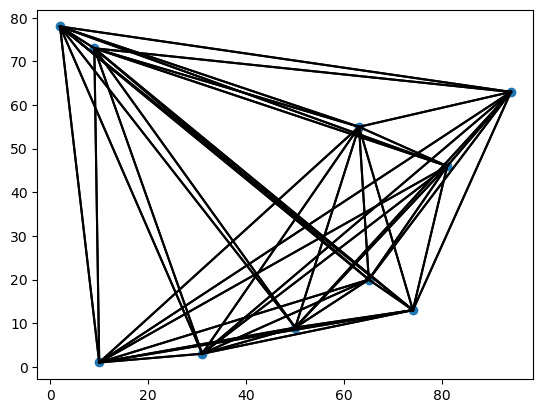

In [48]:
#Generating a graph
n_vertices = 10
#List of points (x,y) that belong to a circumference
#points = [(np.cos(2*np.pi*i/n_vertices),np.sin(2*np.pi*i/n_vertices)) for i in range(n_vertices)]
points = [(random.randint(0,100),random.randint(0,100)) for i in range(n_vertices)]
#Create a graph
graph = Graph(n_vertices)
#Define the adjacency matrix
for i in range(n_vertices):
    for j in range(n_vertices):
        prob = random.random()
        if i != j and prob < 1.1:
            graph.add_edge(i,j,weight=np.sqrt((points[i][0]-points[j][0])**2 + (points[i][1]-points[j][1])**2))

#plot the graph
plt.scatter([p[0] for p in points], [p[1] for p in points])
for i in range(n_vertices):
    for j in range(n_vertices):
        if graph.adjacency_matrix[i][j] != 0:
            plt.plot([points[i][0],points[j][0]],[points[i][1],points[j][1]], color='black')

In [49]:
solver = ACO4TSP(graph, 1000, 2, 2, 0.3)
solver.run(100)

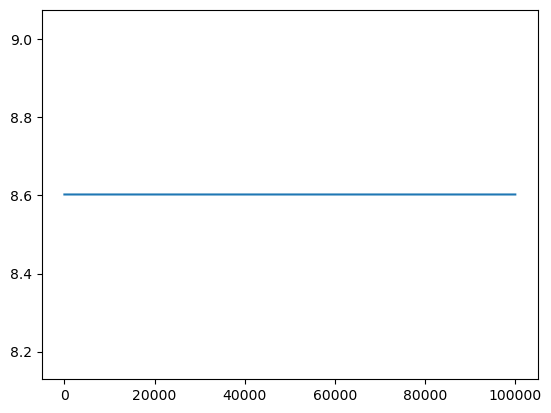

In [50]:
solver.print_history()

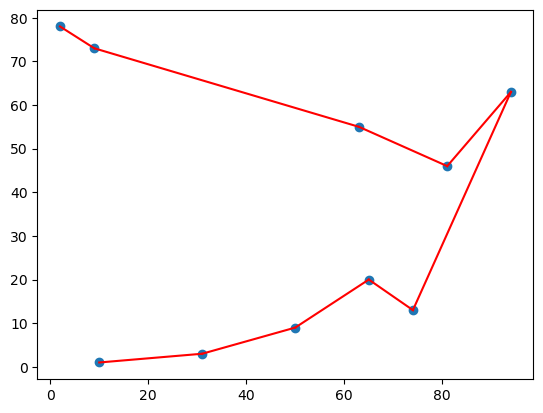

In [51]:
#plot the solution
plt.scatter([p[0] for p in points], [p[1] for p in points])
for i in range(n_vertices):
    plt.plot([points[solver.best_solution[i]][0],points[solver.best_solution[i+1]][0]],[points[solver.best_solution[i]][1],points[solver.best_solution[i+1]][1]], color='red')
plt.show()